# Proprocessing

**Security DS - Proyecto 1**

Roberto Figueroa - 18306

Gustavo Méndez - 18500

## Preprocessing (12M+ records dataset)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import reduce_memory_usage
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

%matplotlib inline
pd.set_option("display.max_columns", None)

**Load dataset and reduce memory usage**

In [2]:
# Load by chunks, due to dataset size (~4 GB if unzipped)
chunk_samples = []
CHUNK_SIZE = 10 ** 6

for chunk in pd.read_csv('./datasets/final_sample.csv.zip', index_col=[0], chunksize=CHUNK_SIZE):
    reduced_chunk = reduce_memory_usage(chunk, verbose=False)
    chunk_samples.append(reduced_chunk)
    
df = pd.concat(chunk_samples, ignore_index=True)
del chunk_samples

### EDA Recap

We have generated a 12M+ records datasets, with 4 different labels. The current label distribution is shown below: 

In [3]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)


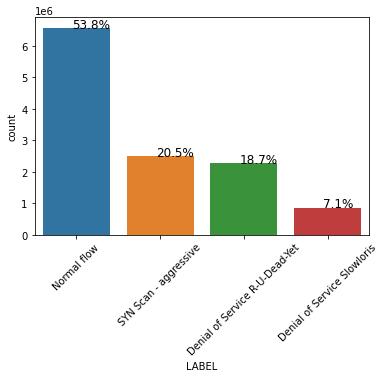

In [4]:
ax = sns.countplot(x="LABEL", data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
without_hue(ax, df['LABEL'])

Clearly, we need to focus on dealing with label imbalance, but not before preprocessing the current data.

### Preprocess summary

**Columns to remove**

 ['BIFLOW_DIRECTION', 'FIREWALL_EVENT', 'FLOW_ACTIVE_TIMEOUT', 'FLOW_INACTIVE_TIMEOUT', 'FRAME_LENGTH', 'MAX_IP_PKT_LEN', 'MIN_IP_PKT_LEN', 'SAMPLING_INTERVAL', 'L7_PROTO_NAME', 'FLOW_START_SEC', 'FLOW_END_SEC', 'TCP_FLAGS']

**Encode and Feature Derivation**
- LABEL (OneHotEncode)
- PROTOCOL (Bin -> OneHotEncode)
- PROTOCOL_MAP (OneHotEncode)
- TOS [Type Of Service] (Bin Right Shift -> OneHotEncode)

**Normalization**
- Standard Scaling (avoided, resume it on data traning split)

**Data Balancing**
- Oversampling and Undersampling


### Remove colums

We are going to drop columns that have same value in all rows. Also this is important to flush some memory

In [5]:
df.drop(['BIFLOW_DIRECTION', 
          'FIREWALL_EVENT', 
          'FLOW_ACTIVE_TIMEOUT', 
          'FLOW_START_SEC',
          'FLOW_END_SEC',
          'FLOW_INACTIVE_TIMEOUT', 
          'FRAME_LENGTH', 
          'MAX_IP_PKT_LEN', 
          'MIN_IP_PKT_LEN', 
          'SAMPLING_INTERVAL',
          'L7_PROTO_NAME', 
        'IPV4_DST_ADDR',
        'IPV4_SRC_ADDR',
         'TCP_FLAGS',
        'DST_TO_SRC_SECOND_BYTES',
        'SRC_TO_DST_SECOND_BYTES'
], axis=1, inplace=True)

### Encode and Feature Derivation

In [6]:
label_df = pd.get_dummies(df["LABEL"], columns=["LABEL"])
label_df.rename(columns={"Denial of Service R-U-Dead-Yet" : "DDOS_RUDY",
                         "Denial of Service Slowloris" : "DDOS_SLOWLORIS",
                        "Normal flow" : "NORMAL_FLOW",
                        "SYN Scan - aggressive" : "SYN_SCAN"}, inplace=True)

df = pd.concat([df, label_df], axis=1)
df.drop("LABEL", axis=1, inplace=True)

del label_df

df.head()

,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_ID,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL,PROTOCOL_MAP,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,DDOS_RUDY,DDOS_SLOWLORIS,NORMAL_FLOW,SYN_SCAN
0,0,1616660040,339,0,1616660040010,2293398,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,6,tcp,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,0,0,1,0
1,0,1616660040,0,0,1616660040068,2293400,1616660040068,68,1,0,0,1616660040,0,0,0,0,1,icmp,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,0,0,1,0
2,0,1616660040,44725,44,1616660040114,2293404,1616660040070,189,2,24650,443,1616660040,0,0,104,2,6,tcp,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,0,0,1,0
3,0,1616660040,0,0,1616660040122,2293407,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,6,tcp,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,0,0,1,0
4,0,1616660040,1114,1,1616660040184,2293409,1616660040183,189,2,443,39762,1616660040,0,0,40,1,6,tcp,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,0,0,1,0


In [7]:
protocol_array = df['PROTOCOL'].apply(lambda x : format(x, "b").zfill(6)).to_numpy(dtype=object)
protocol_array = np.array([list(binary) for binary in protocol_array])
df_protocol = pd.DataFrame(protocol_array, columns=["URG", "ACK", "PSH", "RST", "SYN", "FIN"])

df = pd.concat([df, df_protocol], axis=1)
df.drop("PROTOCOL", axis=1, inplace=True)

del protocol_array
del df_protocol

df.head()

,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_ID,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL_MAP,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,DDOS_RUDY,DDOS_SLOWLORIS,NORMAL_FLOW,SYN_SCAN,URG,ACK,PSH,RST,SYN,FIN
0,0,1616660040,339,0,1616660040010,2293398,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,tcp,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,0,0,1,0,0,0,0,1,1,0
1,0,1616660040,0,0,1616660040068,2293400,1616660040068,68,1,0,0,1616660040,0,0,0,0,icmp,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,0,0,1,0,0,0,0,0,0,1
2,0,1616660040,44725,44,1616660040114,2293404,1616660040070,189,2,24650,443,1616660040,0,0,104,2,tcp,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,0,0,1,0,0,0,0,1,1,0
3,0,1616660040,0,0,1616660040122,2293407,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,tcp,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,0,0,1,0,0,0,0,1,1,0
4,0,1616660040,1114,1,1616660040184,2293409,1616660040183,189,2,443,39762,1616660040,0,0,40,1,tcp,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,0,0,1,0,0,0,0,1,1,0


In [8]:
# Memory optimization
df.astype({"URG": np.uint8, 
                "ACK": np.uint8,
               "PSH": np.uint8, 
               "RST": np.uint8,
               "SYN": np.uint8,
               "FIN": np.uint8}, copy=False)


,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_ID,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,PROTOCOL_MAP,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,DDOS_RUDY,DDOS_SLOWLORIS,NORMAL_FLOW,SYN_SCAN,URG,ACK,PSH,RST,SYN,FIN
0,0,1616660040,339,0,1616660040010,2293398,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,tcp,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,0,0,1,0,0,0,0,1,1,0
1,0,1616660040,0,0,1616660040068,2293400,1616660040068,68,1,0,0,1616660040,0,0,0,0,icmp,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,0,0,1,0,0,0,0,0,0,1
2,0,1616660040,44725,44,1616660040114,2293404,1616660040070,189,2,24650,443,1616660040,0,0,104,2,tcp,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,0,0,1,0,0,0,0,1,1,0
3,0,1616660040,0,0,1616660040122,2293407,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,tcp,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,0,0,1,0,0,0,0,1,1,0
4,0,1616660040,1114,1,1616660040184,2293409,1616660040183,189,2,443,39762,1616660040,0,0,40,1,tcp,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12207868,0,1618262463,14015728,14015,1618262477935,85888693,1618262463919,240,4,53,39394,1618262477,0,0,480,4,udp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85888693,0,0,1,0,0,1,0,0,0,1
12207869,0,1618262477,0,0,1618262477940,85888694,1618262477940,40,1,3446,55411,1618262477,0,0,0,0,tcp,0,0,0,0,1024,0,1024,0,0,0,0,0,40,0,85888694,0,0,1,0,0,0,0,1,1,0
12207870,0,1618262473,4921754,4921,1618262477954,85888695,1618262473032,1345,12,22,39140,1618262477,0,0,2127,14,tcp,0,0,0,0,29200,27960,29200,27960,1460,1410,7,7,40,0,85888695,0,0,1,0,0,0,0,1,1,0
12207871,0,1618262477,376,0,1618262477977,85888696,1618262477977,88,1,53,4319,1618262477,0,0,205,1,udp,0,0,0,0,0,0,0,0,0,0,0,0,128,0,85888696,0,0,1,0,0,1,0,0,0,1


In [9]:
protocol_map_df = pd.get_dummies(df["PROTOCOL_MAP"], columns=["PROTOCOL_MAP"])
df = pd.concat([df, protocol_map_df], axis=1)
df.drop("PROTOCOL_MAP", axis=1, inplace=True)

del protocol_map_df

df.head()

,DIRECTION,FIRST_SWITCHED,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_ID,FLOW_START_MILLISECONDS,IN_BYTES,IN_PKTS,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,OOORDER_IN_PKTS,OOORDER_OUT_PKTS,OUT_BYTES,OUT_PKTS,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,TCP_WIN_MIN_IN,TCP_WIN_MIN_OUT,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,TOTAL_FLOWS_EXP,DDOS_RUDY,DDOS_SLOWLORIS,NORMAL_FLOW,SYN_SCAN,URG,ACK,PSH,RST,SYN,FIN,gre,icmp,ipv6-icmp,tcp,udp
0,0,1616660040,339,0,1616660040010,2293398,1616660040010,44,1,60541,22351,1616660040,0,0,40,1,0,0,0,0,1024,0,1024,0,1460,0,0,0,0,0,2293398,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
1,0,1616660040,0,0,1616660040068,2293400,1616660040068,68,1,0,0,1616660040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,2293400,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
2,0,1616660040,44725,44,1616660040114,2293404,1616660040070,189,2,24650,443,1616660040,0,0,104,2,0,0,0,0,122,1634,122,1634,0,0,0,0,0,0,2293404,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
3,0,1616660040,0,0,1616660040122,2293407,1616660040122,52,1,8728,61075,1616660040,0,0,0,0,0,0,0,0,8192,0,8192,0,1440,0,8,0,40,0,2293407,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0
4,0,1616660040,1114,1,1616660040184,2293409,1616660040183,189,2,443,39762,1616660040,0,0,40,1,0,0,0,0,502,0,502,0,0,0,0,0,0,0,2293409,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0


In [10]:
# TOS - Type Of Service, extract Precedence (datagram/packet importance)

# Right Shift 5: extract only the 3 left bits, Precedence will go from 0 to 7 now
df['SRC_PKT_PRECEDENCE'] = df['SRC_TOS'].apply(lambda x : x >> 5)
df['DST_PKT_PRECEDENCE'] = df['DST_TOS'].apply(lambda x : x >> 5)
df.astype({
    "SRC_PKT_PRECEDENCE": np.uint8, 
    "DST_PKT_PRECEDENCE": np.uint8
}, copy=False)

df.drop(columns=["SRC_TOS", "DST_TOS"], axis=1, inplace=True)

# Check values from 0 - 7
print(df["DST_PKT_PRECEDENCE"].value_counts())
print(df["SRC_PKT_PRECEDENCE"].value_counts())

0    11232793
1      677660
5      206997
2       82138
3        4021
4        2571
6        1509
7         184
Name: DST_PKT_PRECEDENCE, dtype: int64
0    11008086
1      660459
5      262517
6      162541
2       98781
3       13655
4        1447
7         387
Name: SRC_PKT_PRECEDENCE, dtype: int64


### Data balancing

We are going to mix down-sampling with over-sampling in order to balance the dataset.

We are going to down-sample Normal Flow label until reach Denial of Service R-U-Dead-Yet label observations amount. 

We are going to over-sample Denial of Service Slowloris until reach Denial of Service R-U-Dead-Yet observations amount.

we are going to down-sample SYN Scan - aggressive until reach Denial of Service R-U-Dead-Yet observations amount.

In [12]:
# Separate majority and minority classes 
df_majority_n_flow = df[df['NORMAL_FLOW'] == 1]
df_minority_slowloris = df[df['DDOS_SLOWLORIS'] == 1]
df_majority_syn_scan = df[df['SYN_SCAN'] == 1]
df_ddos_rydy = df[df['DDOS_RUDY'] == 1]
n_samples_2_reach = df_ddos_rydy.shape[0]
del df

In [13]:
# Upsample minority class (slowloris)
df_minority_upsampled_n_flow = resample(df_majority_n_flow, 
                                 replace=True,
                                 n_samples=n_samples_2_reach,
                                 random_state=127)
del df_majority_n_flow

In [14]:
# Upsample minority class (slowloris)
df_majority_downsampled_slowloris = resample(df_minority_slowloris, 
                                 replace=True,
                                 n_samples=n_samples_2_reach,
                                 random_state=127)
del df_minority_slowloris

In [15]:

df_majority_downsampled_syn_scan = resample(df_majority_syn_scan, 
                                 replace=True,
                                 n_samples=n_samples_2_reach,
                                 random_state=127)
del df_majority_syn_scan

In [16]:

# Combine majority class with upsampled minority class
df = pd.concat([df_minority_upsampled_n_flow, 
                   df_majority_downsampled_slowloris,
                   df_majority_downsampled_syn_scan,
                   df_ddos_rydy])

df = reduce_memory_usage(df, verbose=True)

# Flush some memory
del df_minority_upsampled_n_flow
del df_majority_downsampled_slowloris
del df_majority_downsampled_syn_scan
del df_ddos_rydy



Mem. usage decreased to 1476.60 Mb (11.9% reduction)


<BarContainer object of 4 artists>

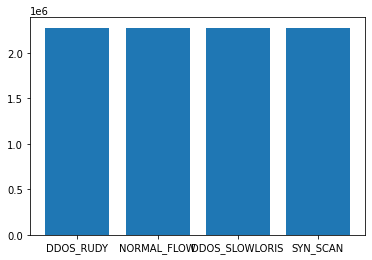

In [17]:
values = [df[df['DDOS_RUDY'] == 1].shape[0],
    df[df['NORMAL_FLOW'] == 1].shape[0],
    df[df['DDOS_SLOWLORIS'] == 1].shape[0],
    df[df['SYN_SCAN'] == 1].shape[0]]
names = ["DDOS_RUDY", "NORMAL_FLOW", "DDOS_SLOWLORIS", "SYN_SCAN"]
plt.bar(names, values)

## Feature Selection

In [19]:
num_col_corr = df.corr()

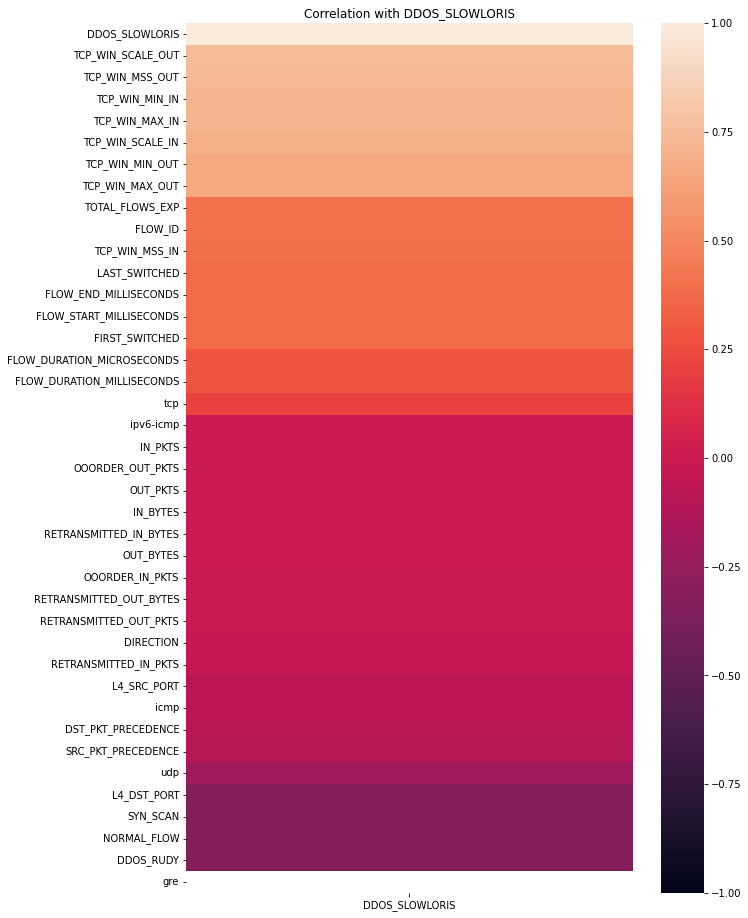

In [23]:
plt.figure(figsize=(10, 16))
full_correlations = num_col_corr[['DDOS_SLOWLORIS']].sort_values(by="DDOS_SLOWLORIS", ascending=False)
# Most correlated variables with 'status'
hm = sns.heatmap(full_correlations, vmin=-1, vmax=1)
hm.set_title('Correlation with DDOS_SLOWLORIS')
plt.show()

## Normalization

After we selected our features for the models implementation, we need to normalize our data!

In [25]:
# Standard Scaler only to some columns...
"""

ignore_col_names = [
    'DIRECTION', 'FIRST_SWITCHED', 'FLOW_END_MILLISECONDS', 'FLOW_START_MILLISECONDS', 'LAST_SWITCHED',
    'SRC_PKT_PRECEDENCE', 'DST_PKT_PRECEDENCE', 'DDOS_RUDY', 'DDOS_SLOWLORIS', 'NORMAL_FLOW', 'SYN_SCAN', 
    'URG', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 
    'gre', 'icmp', 'ipv6-icmp', 'tcp', 'udp'     
]
features_to_scale = [val for val in list(df.columns) if val not in ignore_col_names]

# Chunks for memory usage optimization
x = 4
chunk_simple_list =  lambda my_list, x: [my_list[i:i+x] for i in range(0, len(my_list), x)]
chunked_features_to_scale = chunk_simple_list(features_to_scale, x)
print(chunked_features_to_scale)

for chunk_features in chunked_features_to_scale:
    print('SCALING NOW: ', chunk_features)
    df_to_scale = df[chunk_features]
    ct = ColumnTransformer([
            ('transformer_name', StandardScaler(), chunk_features)
        ], remainder='passthrough')

    df_scaled_values = ct.fit_transform(df_to_scale)
    scaled_features_df = pd.DataFrame(df_scaled_values, index=df_to_scale.index, columns=df_to_scale.columns)
    for col_name in chunk_features:
        df[col_name] = scaled_features_df[col_name]
    
    del ct, scaled_features_df, df_scaled_values, df_to_scale

"""
df = reduce_memory_usage(df, verbose=True)

Mem. usage decreased to 1476.60 Mb (0.0% reduction)


After scaling, we have to reduce memory usage on new float values!

## Save dataset

In [24]:
# Save new df as preprocessed_dataset.csv.zip